## 1.- Tracking del carro 

Para la segmentación del carro probablemente sea conveniente hacer una clase la cual permita abrir el gif y separarlo en un montículo de imágenes. 

In [3]:
#Importación de librerias que necesitaremos
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import rc

In [4]:
class GIFSeparator:
    
    def __init__(self,path):
        vc = cv2.VideoCapture(path)
        #Obtenemos el número de imágenes del video
        nFrames = np.uint8(vc.get(cv2.CAP_PROP_FRAME_COUNT))
        fRate = vc.get(cv2.CAP_PROP_FPS)
        self.fRate = fRate
        ret,f = vc.read()
        n = f.shape[0]
        m = f.shape[1]
        #Creamos el stack de imágenes
        self.frameStack = np.zeros((n,m,nFrames))
        self.nFrames = nFrames
        self.n = n
        self.m = m
        i = 0
        #Vamos a extraer todos los frames y se almacenaran en una pila de imagenes 
        #frame stack
        for i in range(0,nFrames):
            self.frameStack[:,:,i] = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
            #Leemos la siguiente imágen del gif 
            ret,f = vc.read()
        vc.release()
    
    #Obtiene el frame especificado en index
    def getImg(self,index):
        if(index > self.nFrames-1):
            print("Index is out of bounds")
        else:
            return self.frameStack[:,:,index]
        
    #Obtiene el stack de imágenes
    def getImgStack(self):
        return self.frameStack
    
    #Getters para las dimensiones de la imagen
    def getHeight(self):
        return self.n
    
    def getWidth(self):
        return self.m
    
    def getFrameRate(self):
        return self.fRate
            

Text(0.5, 1.0, 'Frame 10')

<Figure size 432x288 with 0 Axes>

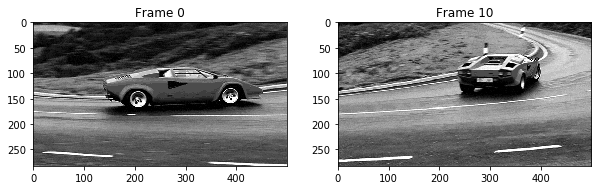

In [5]:
#Prueba de funcionamiento del separador de imágenes del GIF
gif = GIFSeparator('red_car.gif')

plt.figure()
fig, ax = plt.subplots(1,2,figsize=(10, 3.5))
ax[0].imshow(gif.getImg(0),cmap = 'gray')
ax[0].set_title('Frame 0')
ax[1].imshow(gif.getImg(9),cmap= 'gray')
ax[1].set_title('Frame 10')

Para el tracking del auto lo que se me ocurría era usar como tal snakes, la metodología es muy simple, hay que encontrar una snake que se adhiera bien al carro en la primera imagen, minimizar, usar la snake resultante como contorno inicial para el siguiente frame, etc. Los funcionales de enrgía deberian ser tales que la snake pueda seguir bien el mínimo de energía que corresponde a los cambios que sufre el carro de cuadro a cuadro. 

Aquí especialmente, como el carro parece estar moviendose hacia dentro de la hoja conforme da la vuelta necesitamos un snake con una energía interna en la que los terminos de segundo orden predominen (i.e. $\beta$ alta). 

In [6]:
class SnakeTracker:
    
    imgStack = None
    initialContourX = None
    initialContourY  = None
    contourColor = "#80ff80"
    alpha = None
    beta = None
    wEdge = None
    wLine = None
    wTermination = None
    
    def __init__(self,imgStack):
        self.imgStack = imgStack
    
    def placeInitialContour(self,x,y):
        #En un contorno el primer y último puntos deben ser iguales así que hay que verificar eso 
        nx = np.size(x)
        ny = np.size(y)
        epsilon = 0.001
        if(np.abs(x[0] - x[nx-1]) > epsilon or np.abs(y[0] - y[ny-1]) > epsilon):
            print("Invalid contour, first and last points must be the same")
        else:
            self.initialContourX = x
            self.initialContourY = y
    
    def plotInitialContour(self):
        if(self.initialContourX is None or self.initialContourY is None):
            print("No initial contour has been placed")
        else:
            plt.figure()
            plt.title("Initial contour")
            #Mostramos la primera imagen 
            plt.imshow(self.imgStack[:,:,0],cmap = "gray")
            #Mostramos el contorno
            plt.plot(self.initialContourX,self.initialContourY,color = self.contourColor)
            plt.show()
    
    #Alpha y beta para las energias de deformación en membrana y placa, y pesos para que tanto queremos que se adhiera
    #a las lineas, bordes y terminaciones
    def initializeSnake(self,alpha,beta,wLine,wEdge):
        self.alpha = alpha
        self.beta = beta
        self.wLine = wLine
        self.wEdge = wEdge
    
    def track(self):
        if(self.alpha is None or self.beta is None or self.wLine is None or self.wEdge is None):
            print("Snake parameters have not been set")
        else:
            frames = self.imgStack.shape[2]
            initSnake = np.zeros((self.initialContourX.size,2))
            initSnake[:,0] = self.initialContourX
            initSnake[:,1] = self.initialContourY
            snakes = np.zeros((self.initialContourX.size,2,frames))
            for i in range(0,frames):
                currentImg = self.imgStack[:,:,i]
                #Obtain the snake
                snake = active_contour(gaussian(currentImg, 5),initSnake, alpha = self.alpha, beta=self.beta, w_line = self.wLine, w_edge = self.wEdge)
                #The old snake is the new snake B)
                initSnake = snake
                #Guardamos la snake en un arreglo
                snakes[:,:,i] = snake
            self.snakes = snakes
            return snakes

    
    def plotSnake(self,i):
        self.ax.clear()
        self.ax.imshow(self.imgStack[:,:,i],cmap = "gray")
        self.ax.plot(self.snakes[:,0,i],self.snakes[:,1,i],linewidth=3,color = self.contourColor)
        
    def generateTrackAnimation(self,fRate):
        milisFRate = (1/fRate)*1000;
        self.fig, self.ax = plt.subplots()
        ani = FuncAnimation(self.fig, self.plotSnake, frames = self.imgStack.shape[2],interval = milisFRate, blit = False);
        return HTML(ani.to_html5_video())
   
    
    
        
                
        
        
        

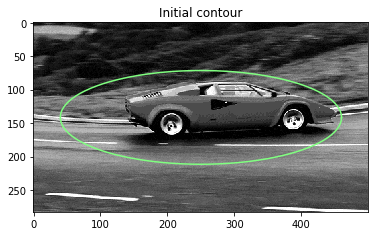

In [7]:
tracker = SnakeTracker(gif.getImgStack())
#Vamos a crear un contorn elíptico centrado en el medio 
x0 = gif.getWidth()/2
y0 = gif.getHeight()/2

t = np.linspace(0,2*np.pi,100)
r1 = 210
r2 = 70
contourX = x0 + r1*np.cos(t)
contourY = y0 + r2*np.sin(t)

tracker.placeInitialContour(contourX,contourY)
tracker.plotInitialContour()

C:\Users\walup\anaconda3\lib\site-packages\ipykernel_launcher.py:59: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.


<Figure size 432x288 with 0 Axes>

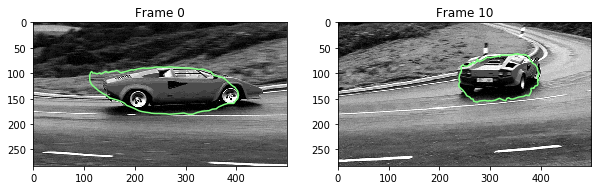

In [8]:

#Vamos a probar algunos parámetros para nuestra snake
alpha = 10
beta = 100
wLine = 0
wBorder = 50
tracker.placeInitialContour(contourX,contourY)
tracker.initializeSnake(alpha,beta,wLine,wBorder)
snakes = tracker.track()

plt.figure()
fig, ax = plt.subplots(1,2,figsize=(10, 3.5))
#La primera imagen con su snake resultante
ax[0].imshow(tracker.imgStack[:,:,0],cmap = 'gray')
ax[0].plot(snakes[:,0,0],snakes[:,1,0],color = "#80ff80")
ax[0].set_title('Frame 0')

#La decima imagen con su snake resultante
ax[1].imshow(tracker.imgStack[:,:,9],cmap= 'gray')
ax[1].plot(snakes[:,0,9],snakes[:,1,9],color = "#80ff80")
ax[1].set_title('Frame 10')
plt.show()


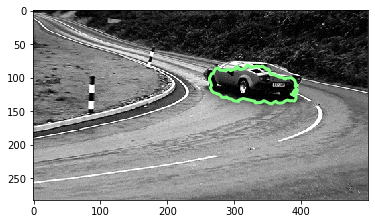

In [345]:
tracker.generateTrackAnimation(gif.getFrameRate())

## 2.- Segmentación de los ventriculos


Para la segmentación de los ventriculos, me gustaría hacerlo tanto con Spiders, como con las técnicas de crecimiento de regiones que se exploraron en clase, en este último caso probablemente debamos implementar nuestra propia función pero me parecieron interesantes así que creo que voy a intentarlo

In [455]:
class Segmentator:
    contourColor = "#80ff80"
    def __init__(self,img):
        self.img = img
        self.n, self.m = img.shape
        print(self.n)
        print(self.m)
        
    #Estos primeros métodos para la implementación de region growing
    def getConnectivityArray(self,x,y,conn):
        if(conn == 4):
            return [[x-1,y],[x+1,y],[x,y-1],[x,y+1]]
        elif(conn == 8):
            return [[x-1,y],[x+1,y],[x,y-1],[x,y+1],[x-1,y-1],[x-1,y+1],[x+1,y-1],[x+1,y+1]]
        else:
            print("Connectiviy has to be either 8 or 4")
        
    
    def regionGrowingSegmentation(self,seeds,thresh, conn):
        segmentedImg = np.zeros((self.n,self.m))
        for s in range(len(seeds)):
            seed = seeds[s]
            #La primera cosa q ue haremos es añadir la semilla a un stack 
            stack = []
            stack.append([seed[0],seed[1]])
            segmentedImg[seed[1],seed[0]] = 255
            #En cuanto agreguems un elemento al stack 
            while(len(stack) > 0):
                point = stack.pop()
                connectionPoints = self.getConnectivityArray(point[0],point[1],conn)
                for i in range(len(connectionPoints)):
                    exPoint = connectionPoints[i]
                    x = exPoint[0]
                    y = exPoint[1]
                    if(x >= 0 and x < self.m and y >= 0 and y < self.n):
                        pixDist = np.abs(float(self.img[seed[1],seed[0]])-float(self.img[y,x]))
                        if(pixDist <= thresh and segmentedImg[y,x] == 0):
                            stack.append(exPoint)
                            segmentedImg[y,x] = 255
        return segmentedImg
    
    def setInitialSnake(self, xContour, yContour,alpha, beta, wEdge, wLine):
        self.xContour = xContour
        self.yContour = yContour
        self.alpha = alpha
        self.beta = beta
        self.wEdge = wEdge
        self.wLine = wLine
        plt.figure()
        plt.title("Contorno inicial")
        #Mostramos la primera imagen 
        plt.imshow(self.img,cmap = "gray")
        #Mostramos el contorno
        plt.plot(self.xContour,self.yContour,color = self.contourColor)
        plt.show()
    
    def snakeSegmentation(self):
        initSnake = np.zeros((self.xContour.size,2))
        initSnake[:,0] = self.xContour
        initSnake[:,1] = self.yContour
        snake = active_contour(gaussian(self.img, 2),initSnake,alpha = self.alpha, beta = self.beta,w_line = self.wLine, w_edge = self.wEdge)
        segmentedImg = np.zeros((self.n,self.m))
        
        for i in range(len(snake)):
            pt = snake[i]
            segmentedImg[int(pt[1]),int(pt[0])] = 255
        kernel = np.ones((5,5),np.uint8)
        segmentedImg = cv2.dilate(segmentedImg,kernel,iterations = 1)
        #Ahora que tenemos el contorno hay que llenarlo
        h, w = segmentedImg.shape
        mask = np.zeros((h + 2, w + 2), np.uint8)
        segmentedImg = segmentedImg.astype("uint8")
        cv2.floodFill(segmentedImg, mask, (0, 0), 255)
        segmentedImg = cv2.bitwise_not(segmentedImg)
        return snake,segmentedImg
    
    

### Segmentación utilizando crecimiento de región 

806
650


<Figure size 432x288 with 0 Axes>

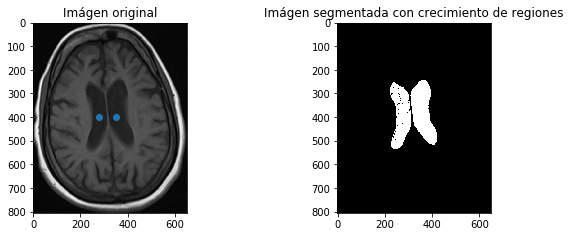

In [456]:
brainImg = cv2.imread("brain.jpg")
brainImg = cv2.cvtColor(brainImg, cv2.COLOR_BGR2GRAY)
segmentator = Segmentator(brainImg)
thresh = 10
conn = 8
seeds = [[350,400],[280,400]]
segmentedImg = segmentator.regionGrowingSegmentation(seeds,thresh,conn)

plt.figure()
fig, ax = plt.subplots(1,2,figsize=(10, 3.5))
#La primera imagen con su snake resultante
ax[0].imshow(brainImg,cmap = 'gray')
ax[0].set_title('Imágen original')
ax[0].scatter([350,280],[400,400])
#La decima imagen con su snake resultante
ax[1].imshow(segmentedImg,cmap= 'gray')
ax[1].set_title('Imágen segmentada con crecimiento de regiones')
plt.show()


### Segmentación utilizando Snakes

Haremos la segmentación individual de cada ventriculo

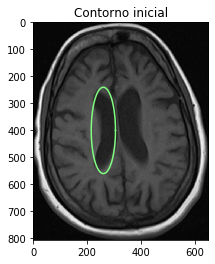

C:\Users\walup\anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.


In [457]:
#Primer ventriculo
#Los parámetros del Snake
alpha = 5
beta = 0
wLine = 0
wBorder = 100

x0 = 260
y0 = 400
t = np.linspace(0,2*np.pi,1000)
r1 = 45
r2 = 160
contourX = x0 + r1*np.cos(t)
contourY = y0 + r2*np.sin(t)

segmentator.setInitialSnake(contourX,contourY,alpha,beta,wEdge,wLine)
leftSnake,segmentedLeft = segmentator.snakeSegmentation()

<Figure size 432x288 with 0 Axes>

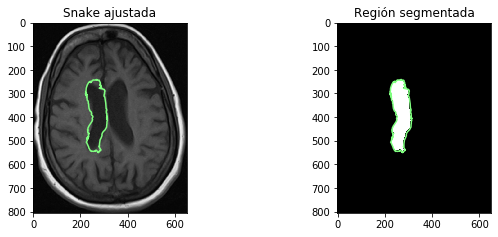

In [458]:
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(10, 3.5))
ax[0].imshow(segmentator.img,cmap = 'gray')
ax[0].plot(leftSnake[:,0],leftSnake[:,1],color = "#80ff80")
ax[0].set_title('Snake ajustada')
ax[1].imshow(segmentedLeft,cmap= 'gray')
ax[1].plot(leftSnake[:,0],leftSnake[:,1],color = "#80ff80")
ax[1].set_title('Región segmentada')
plt.show()

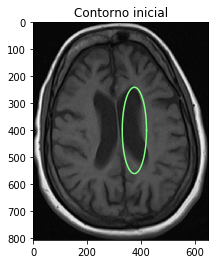

C:\Users\walup\anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.


In [459]:
#Los parámetros del Snake
alpha = 5
beta = 0
wLine = 0
wBorder = 100

x0 = 375
y0 = 400
t = np.linspace(0,2*np.pi,1000)
r1 = 45
r2 = 160
contourX = x0 + r1*np.cos(t)
contourY = y0 + r2*np.sin(t)

segmentator.setInitialSnake(contourX,contourY,alpha,beta,wEdge,wLine)
rightSnake,segmentedRight = segmentator.snakeSegmentation()

<Figure size 432x288 with 0 Axes>

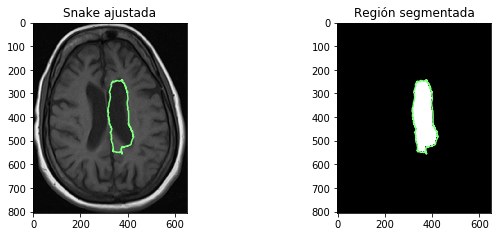

In [461]:
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(10, 3.5))
ax[0].imshow(segmentator.img,cmap = 'gray')
ax[0].plot(rightSnake[:,0],rightSnake[:,1],color = "#80ff80")
ax[0].set_title('Snake ajustada')
ax[1].imshow(segmentedRight,cmap= 'gray')
ax[1].plot(rightSnake[:,0],rightSnake[:,1],color = "#80ff80")
ax[1].set_title('Región segmentada')
plt.show()